In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

In [5]:
a  = np.array([0,0,1])
b = np.array([1,1,1])

def modulus(a):
    mod = 0.
    for c in a:
        mod += c**2
    return np.sqrt(mod)

def normalize(a):
    mod = 0.
    for c in a:
        mod += c**2
    return a/np.sqrt(mod)

def random_point_on_sphere():
    theta = np.arccos(np.random.uniform(-1,1))
    phi = np.random.uniform(0,2*np.pi)
    v = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    return v

In [24]:
class event3:
    
    def __init__(self,total_energy,mode='polar',permute_photons=False):
        self.E = float(total_energy)
        
        if mode == 'polar':
            # assign directions to photons
            v1 = random_point_on_sphere()
            v2 = random_point_on_sphere()

            theta = np.arccos(np.dot(v1,v2))
            alpha = np.random.uniform(0,theta)
            
            self.w = theta
            
            c1 = np.sin(theta - alpha)/np.sin(theta)
            c2 = np.sin(alpha)/np.sin(theta)
            v3 = -c1*v1 - c2*v2
            
            vs = [v1,v2,v3]

            #assign energies to photons
            e3 = self.E/(1 + c1 + c2)
            e2 = e3*c2
            e1 = e3*c1
            
            es = [e1,e2,e3]
            
        elif mode == 'energy_polar':
            # assign directions to photons and energy to the third one
            v1 = random_point_on_sphere()
            v2 = random_point_on_sphere()
            theta = np.arccos(np.dot(v1,v2))
            e3 = self.E*np.random.uniform(1./(1+1/np.cos(0.5*theta)),0.5)
            
            alpha = 0.5*theta + np.arccos((self.E/e3 - 1)*np.cos(0.5*theta))
            c1 = np.sin(theta - alpha)/np.sin(theta)
            c2 = np.sin(alpha)/np.sin(theta)
            v3 = -c1*v1 - c2*v2
            e2 = e3*c2
            e1 = e3*c1
            
            vs = [v1,v2,v3]
            es = [e1,e2,e3]
            
        elif mode == 'energy':
            e1 = np.random.uniform(0,0.5*self.E)
            
            self.w = e1
            
            e2 = np.random.uniform(0.5*self.E - e1,0.5*self.E)
            e3 = self.E - e1 - e2
            theta = np.arccos((e3**2 - e1**2 - e2**2)/(2*e1*e2))
            alpha = 0.5*theta + np.arccos((self.E/e3 - 1)*np.cos(0.5*theta))
            
            v1 = random_point_on_sphere()
            v2aux = random_point_on_sphere()
            v2ort = normalize(v2aux - np.dot(v1,v2aux)*v1)
            v2 = np.cos(theta)*v1 + np.sin(theta)*v2ort
            
            v3 = -e1/e3*v1 - e2/e3*v2
            
            vs = [v1,v2,v3]
            es = [e1,e2,e3]
            
        elif mode == 'cartesian':
            v1 = np.random.uniform(0,1,3)
            v2 = np.random.uniform(0,1,3)
            v3 = -v1 - v2
            unnormalized_energy = modulus(v1) + modulus(v2) + modulus(v3)
            es = [modulus(v)*self.E/unnormalized_energy for v in [v1,v2,v3]]
            vs = [normalize(v) for v in [v1,v2,v3]]
            
        
        if permute_photons:
            indexs = np.random.permutation(3)
            self.vs = np.array([vs[i] for i in indexs])
            self.es = np.array([es[i] for i in indexs])
            
        else:
            self.vs = np.array(vs)
            self.es = np.array(es)
        
    def plot2D(self):
        plt.figure()
        plt.xlim(-self.E/2,self.E/2)
        plt.ylim(-self.E/2,self.E/2)
        plt.plot([0,self.es[0]],[0,0])
        t2 = np.arccos(np.dot(self.vs[0],self.vs[1]))
        plt.plot([0,self.es[1]*np.cos(t2)],[0,self.es[1]*np.sin(t2)])
        t3 = np.arccos(np.dot(self.vs[0],self.vs[2]))
        plt.plot([0,self.es[2]*np.cos(t3)],[0,-self.es[2]*np.sin(t3)])
        plt.show()
        
    def plot3D(self,ax):
        for i,v in enumerate(self.vs):
            ax.plot([0,self.es[i]*v[0]],[0,self.es[i]*v[1]],[0,self.es[i]*v[2]])
        return 
    
def no_Filter(ev):
    return True
    
class total_spectra:
    
    def __init__(self):
        self.energies = []
        self.angles = []
        self.weights = []
        self.n = 0
        
    def measure(self,ev,Filter=no_Filter,use_weights=False):
        if Filter(ev):
            if use_weights:
                self.weights.append(ev.w)
            else:
                self.weights.append(1.)
            if self.energies == []:
                self.n = len(ev.es)
                for i,e in enumerate(ev.es):
                    self.energies.append([e])
                    for j in range(i+1,self.n):
                        self.angles.append([np.arccos(np.dot(ev.vs[i],ev.vs[j]))])
            else:
                c = 0
                for i,e in enumerate(ev.es):
                        self.energies[i].append(e)
                        for j in range(i+1,self.n):
                            self.angles[c].append(np.arccos(np.dot(ev.vs[i],ev.vs[j])))
                            c += 1
                        
                
    def plot_energy_spectra(self,numbins,total_energy,external_ax=[]):
        norm_weights = np.array(self.weights)*len(self.weights)/np.sum(self.weights)
        bins = np.arange(0,0.5*total_energy,0.5*total_energy/numbins)
        ticks = np.arange(0,0.5*total_energy,0.5*total_energy/3)
        if len(external_ax) == 0:
            fig,ax = plt.subplots(1,self.n,sharey=True)
            fig.suptitle('Entries: %d' %np.sum(norm_weights))
        else:
            ax = external_ax
        for i in range(self.n):
            ax[i].set_title('photon %d' %(i+1))
            ax[i].set_xticks(ticks)
            ax[i].hist(self.energies[i],bins=bins,weights=norm_weights,histtype='step')
        return ax
            
    def plot_angular_spectra(self,numbins,external_ax=[]):
        norm_weights = np.array(self.weights)*len(self.weights)/np.sum(self.weights)
        bins = np.arange(0,np.pi,np.pi/numbins)
        ticks = np.arange(0,np.pi,np.pi/3)
        if len(external_ax) == 0:
            fig,ax = plt.subplots(1,int((self.n*(self.n-1))/2),sharey=True)
            fig.suptitle('Entries: %d' %np.sum(norm_weights))
        else:
            ax = external_ax
        c = 0
        for i in range(self.n):
            for j in range(i+1,self.n):
                ax[c].set_title('theta %d-%d' %(i+1, j+1))
                ax[c].set_xticks(ticks)
                ax[c].hist(self.angles[c],bins=bins,weights=norm_weights,histtype='step')
                c += 1
        return ax
    

    
class detectors:
    
    def __init__(self,versors,distances,radii):
        self.versors = np.array(versors) # directions of the detectors
        self.radii = np.array(radii) # radii of the detectors
        self.n = len(self.radii)
        self.distances = np.array(distances) # distances of the detectors from the source
        self.weights = []
        self.acquired_data = []
        for i in range(self.n):
            self.acquired_data.append([])
#         self.activations = [False]*self.n
        
    def reset(self):
        self.weights = []
        self.acquired_data = []
        for i in range(self.n):
            self.acquired_data.append([])
        
    def measure(self,ev,verbose=False,use_weights=False):
        triggered = False
        ens = []
        totE = 0.
        for i,v in enumerate(self.versors):
            triggered = False
            for j,v_ph in enumerate(ev.vs):
                t = np.arccos(np.dot(v,v_ph))
                if t < np.arctan(1.*self.radii[i]/self.distances[i]):
                    ens.append(ev.es[j])
                    totE += ev.es[j]
                    triggered = True
                    break
            if not triggered:
                break
        if not triggered:
            return False
        
        # successfully triggered
        if use_weights:
            self.weights.append(ev.w)
        else:
            self.weights.append(1.)
        if verbose:
            print('Triggered: event %f, total energy %f' %(np.sum(self.weights), totE))
        for i in range(self.n):
            self.acquired_data[i].append(ens[i])
        return True
    
    
    
    def plot_spectra(self,numbins,total_energy):
        norm_weights = np.array(self.weights)*len(self.weights)/np.sum(self.weights)
        bins = np.arange(0,0.5*total_energy,0.5*total_energy/numbins)
        ticks = np.arange(0,0.5*total_energy,0.5*total_energy/3)
        fig,ax = plt.subplots(1,self.n,sharey=True)
        fig.suptitle('Entries: %d' %np.sum(norm_weights))
        for i in range(self.n):
            ax[i].set_title('DET%d' %(i+1))
            ax[i].set_xticks(ticks)
            ax[i].hist(self.acquired_data[i],bins=bins,weights=norm_weights)
            ax[i].plot([total_energy/3,total_energy/3],[0,np.sqrt(np.sum(self.weights))])
        

<IPython.core.display.Javascript object>


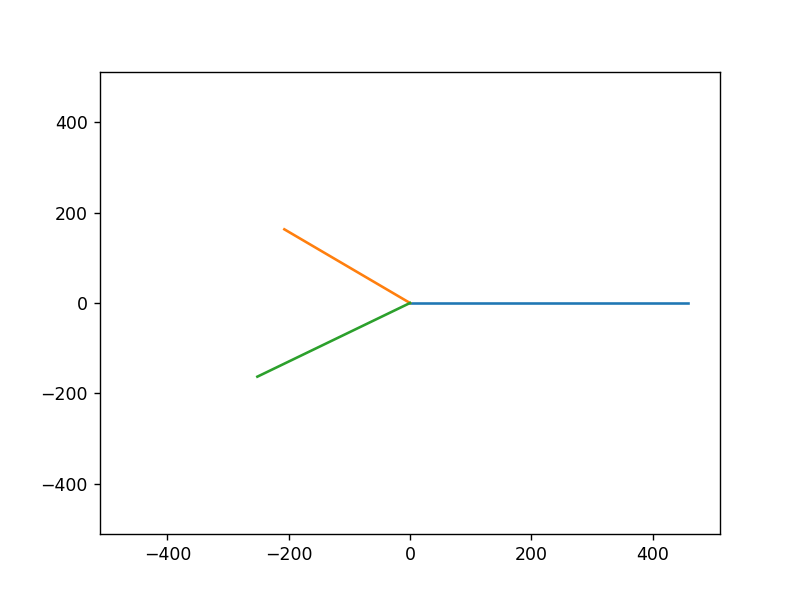

458.69333814108506
263.5362024760256
299.7704593828892
1021.9999999999998 [0. 0. 0.]


In [8]:
# plotting events
%matplotlib notebook
ev = event3(1022,mode='polar')

# fig = pyplot.figure()
# ax = Axes3D(fig)
# ev.plot3D(ax)

ev.plot2D()
e = 0
p = np.array([0.,0.,0.])
for i in range(3):
    e += ev.es[i]
    p += ev.vs[i]*ev.es[i]
    print(ev.es[i])
    
print(e,p)

100%|██████████| 1000000/1000000 [00:51<00:00, 19355.48it/s]

distance = 16.000000


<IPython.core.display.Javascript object>


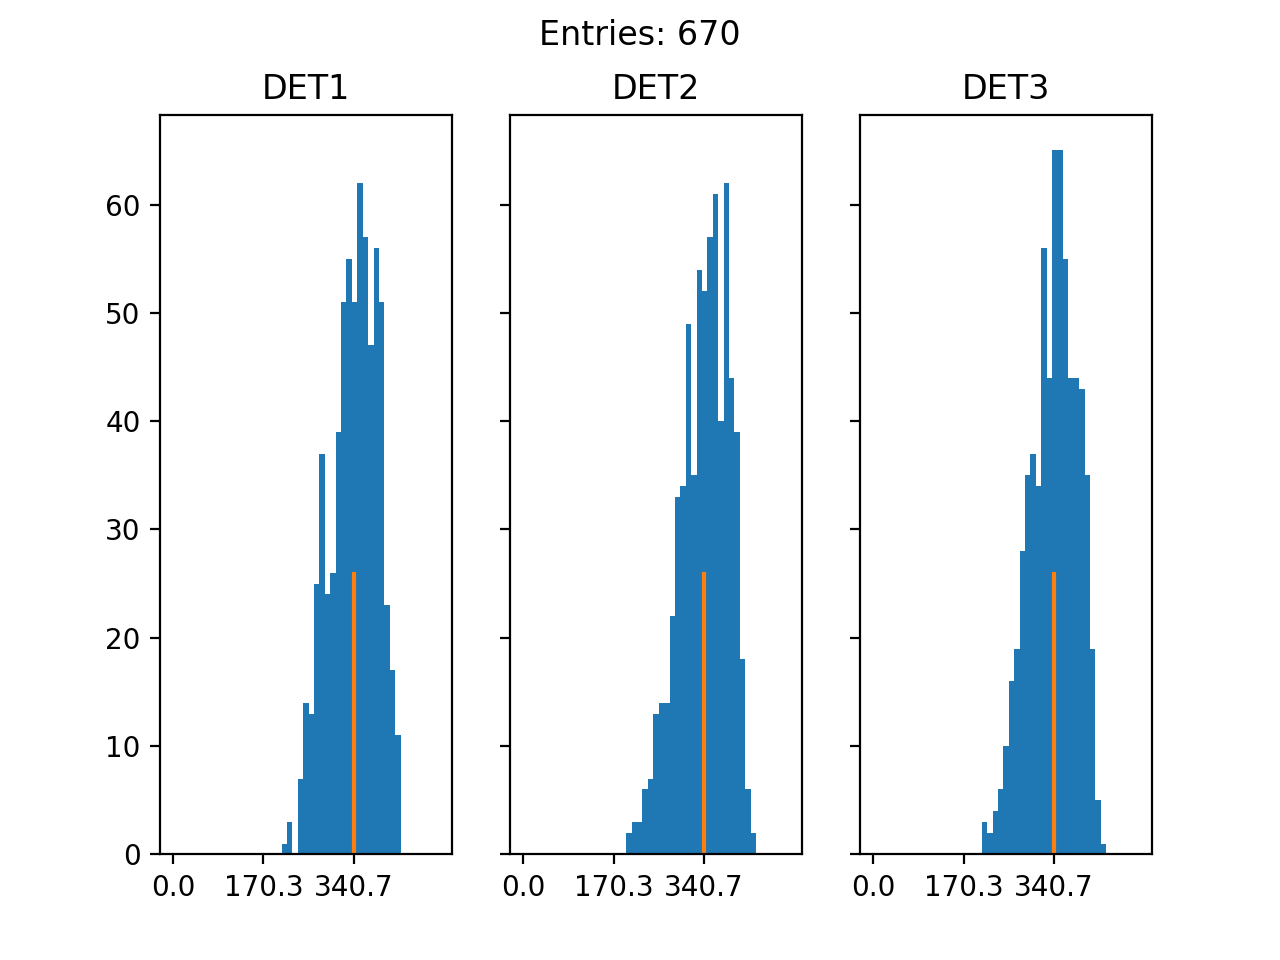

100%|██████████| 1000000/1000000 [00:53<00:00, 18702.22it/s]

distance = 16.500000


<IPython.core.display.Javascript object>


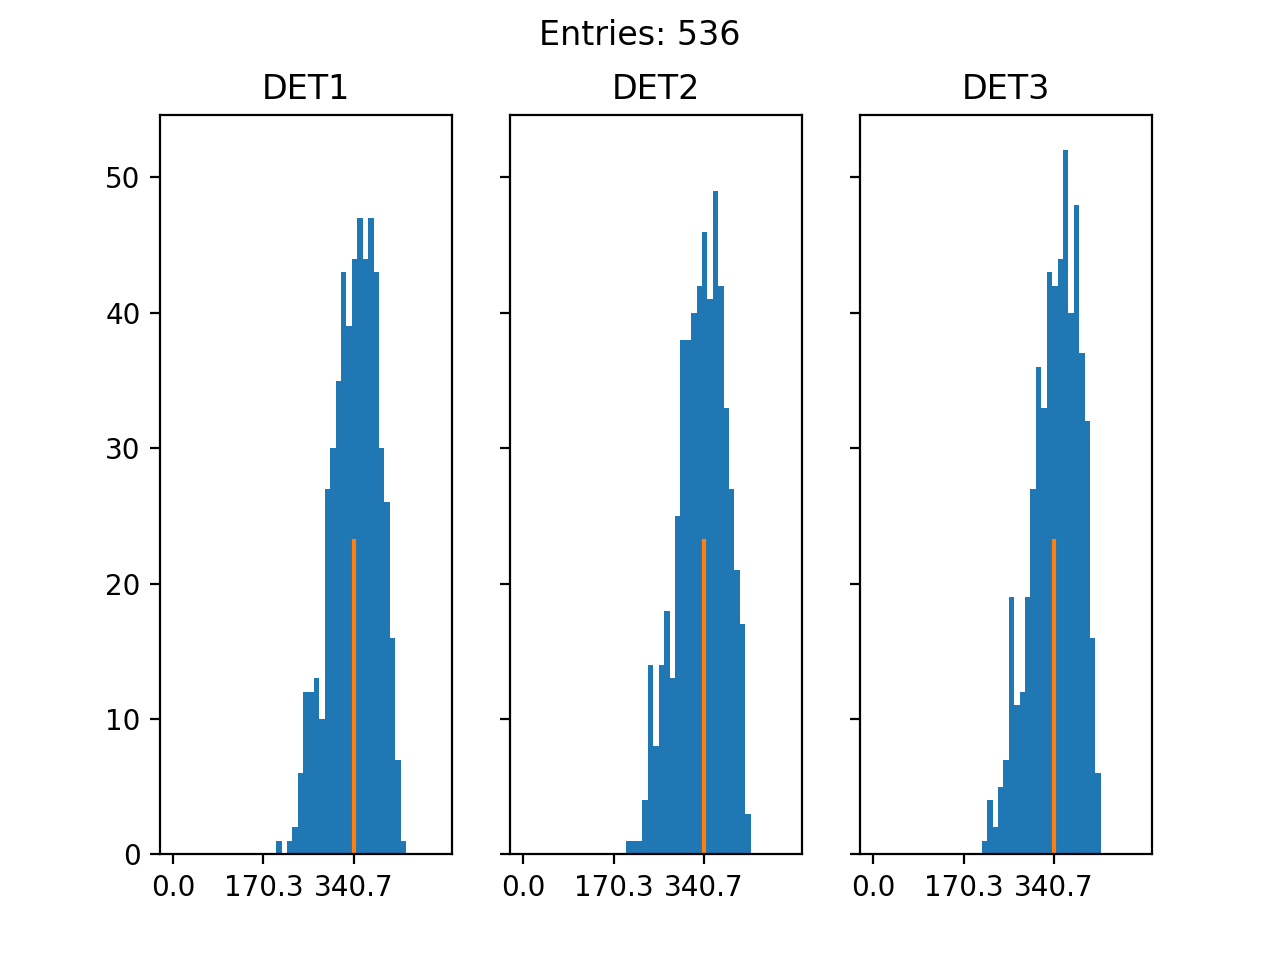

100%|██████████| 1000000/1000000 [00:51<00:00, 19286.39it/s]

distance = 17.000000


<IPython.core.display.Javascript object>


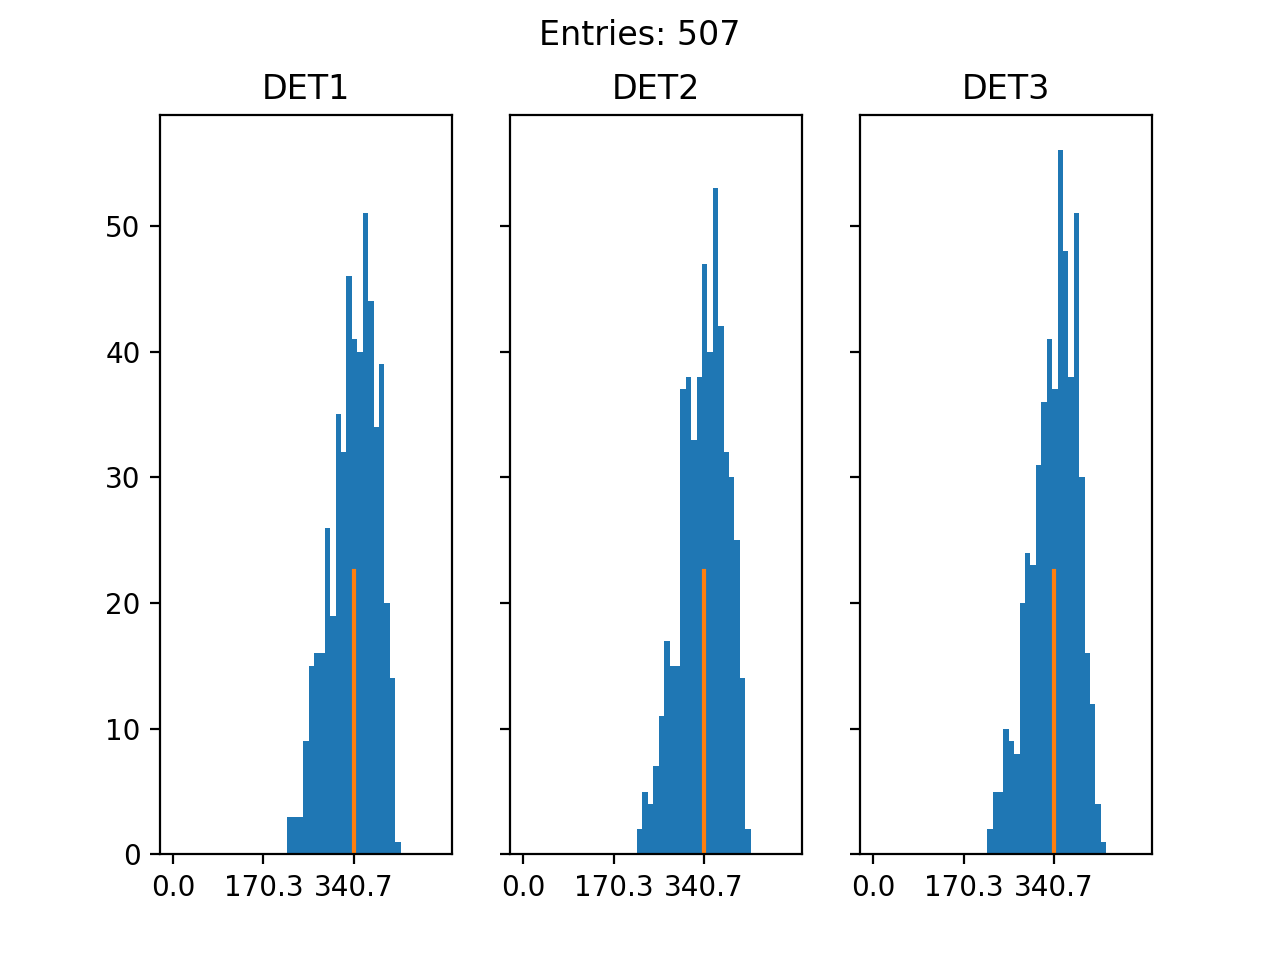

100%|██████████| 1000000/1000000 [00:56<00:00, 17856.03it/s]

distance = 17.500000


<IPython.core.display.Javascript object>


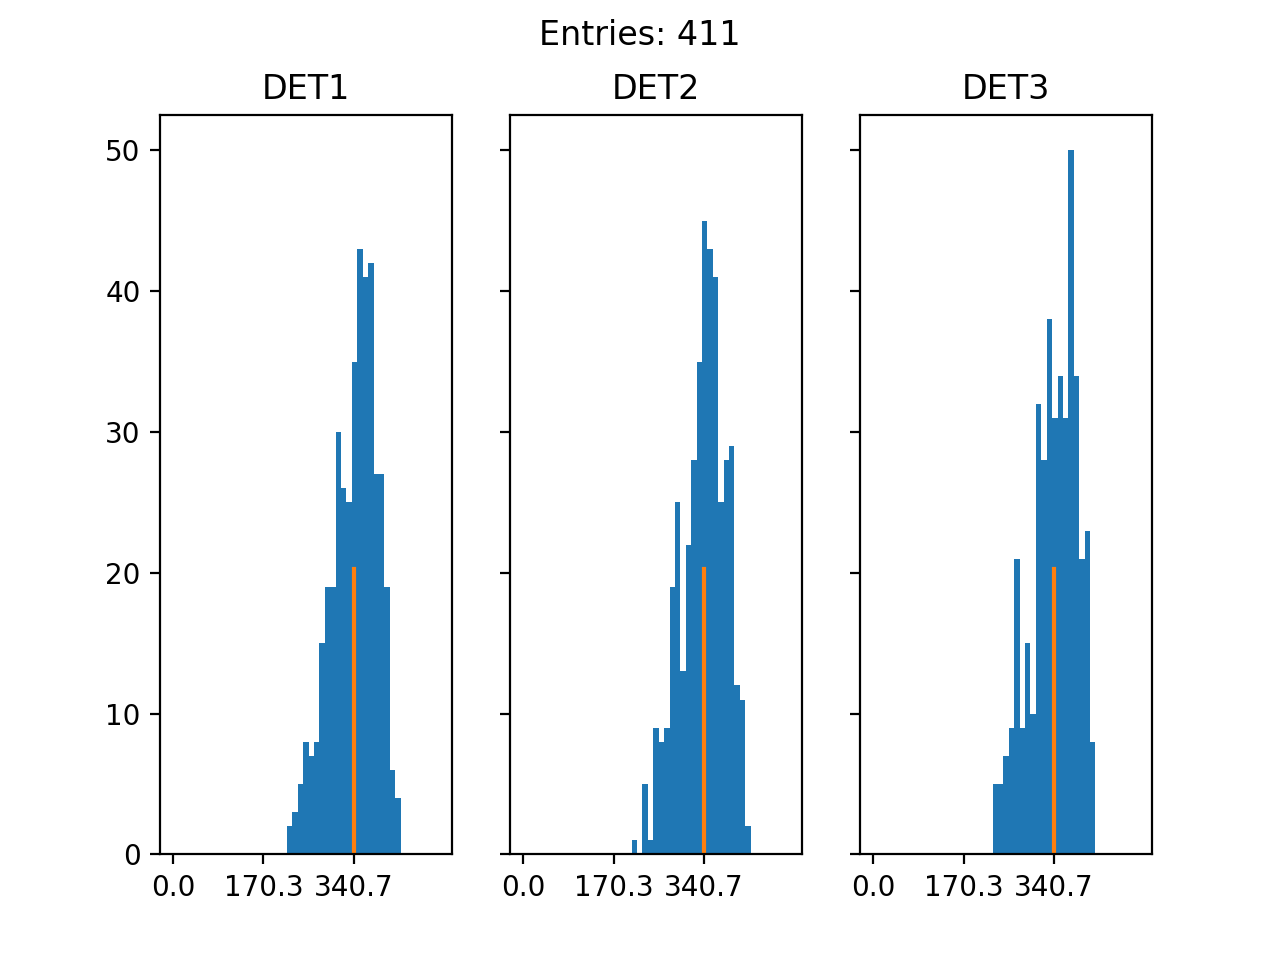

100%|██████████| 1000000/1000000 [00:56<00:00, 17592.43it/s]

distance = 18.000000


<IPython.core.display.Javascript object>


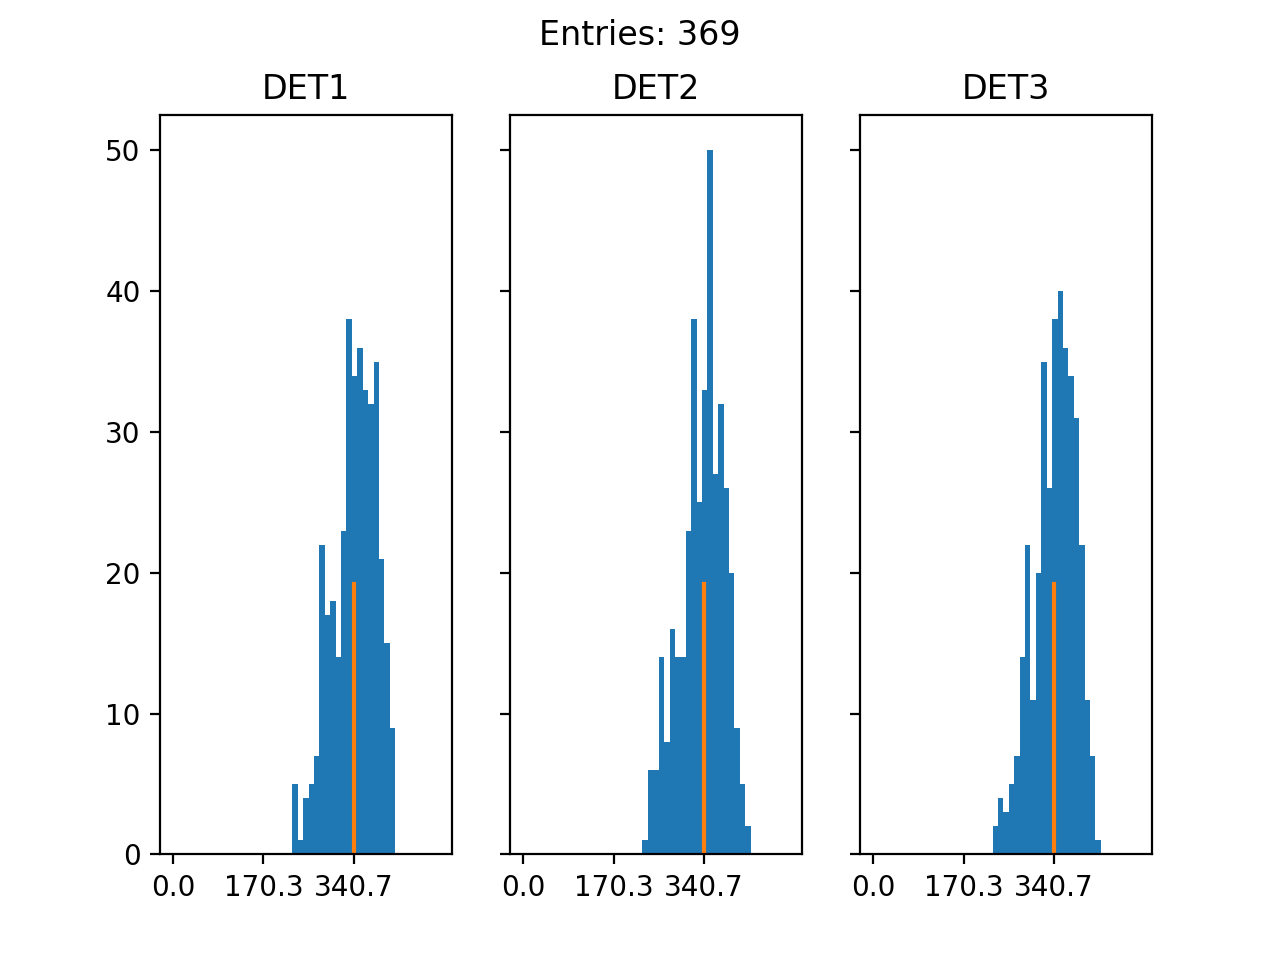

100%|██████████| 1000000/1000000 [00:57<00:00, 17526.80it/s]

distance = 18.500000


<IPython.core.display.Javascript object>


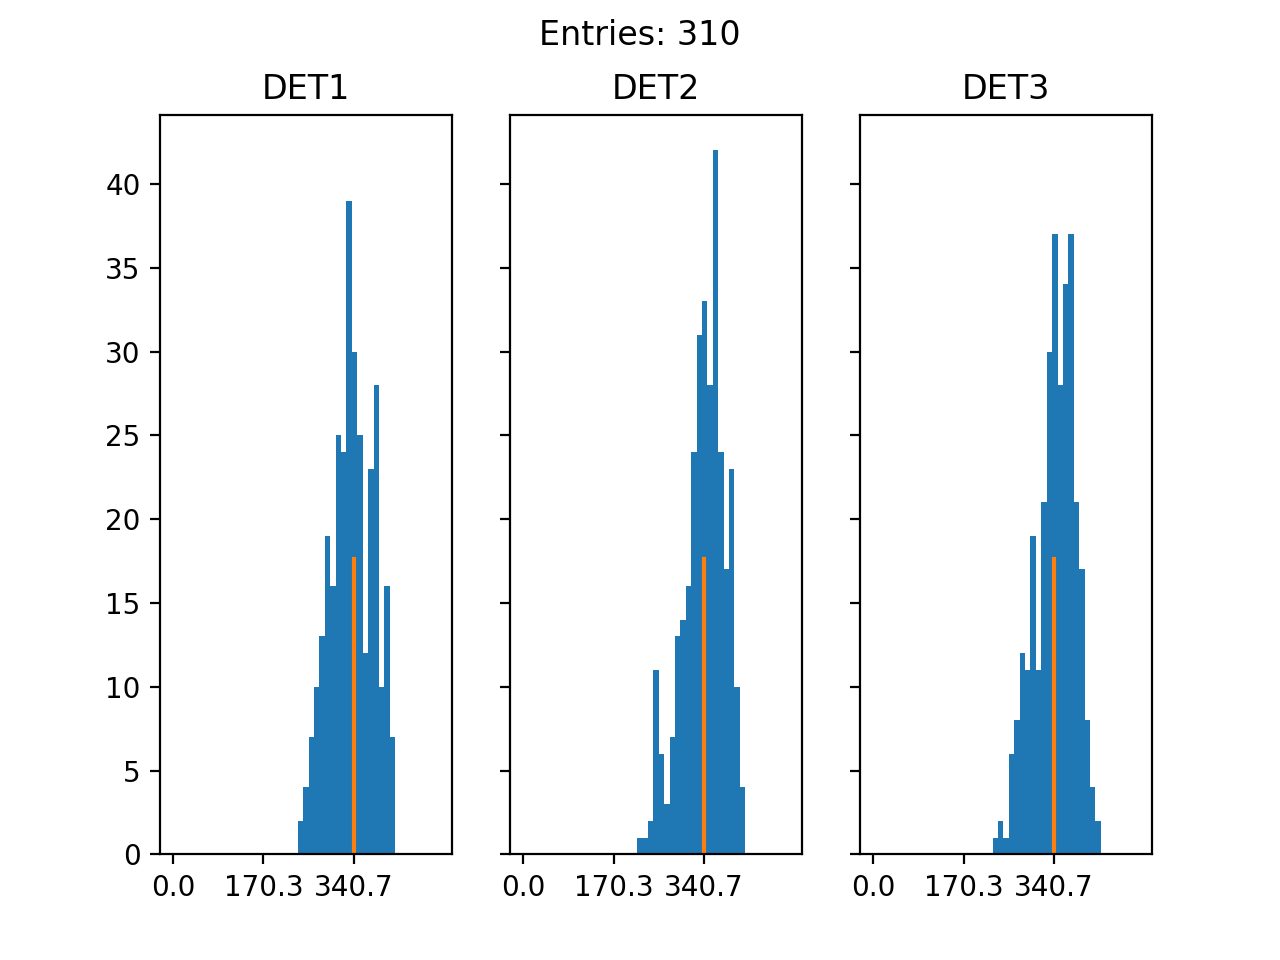

100%|██████████| 1000000/1000000 [00:52<00:00, 19005.41it/s]

distance = 19.000000


<IPython.core.display.Javascript object>


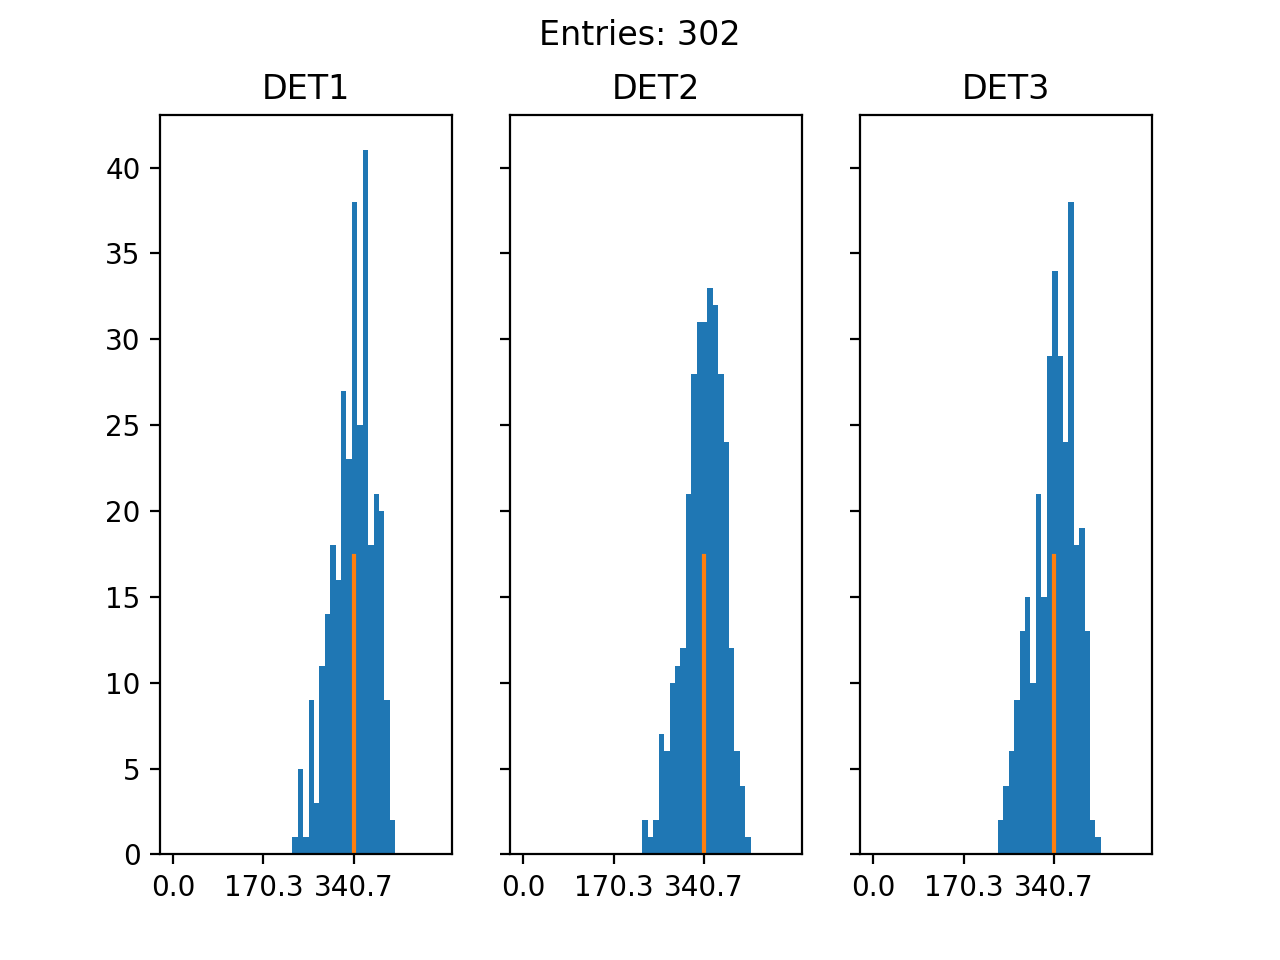

100%|██████████| 1000000/1000000 [00:54<00:00, 18422.27it/s]

distance = 19.500000


<IPython.core.display.Javascript object>


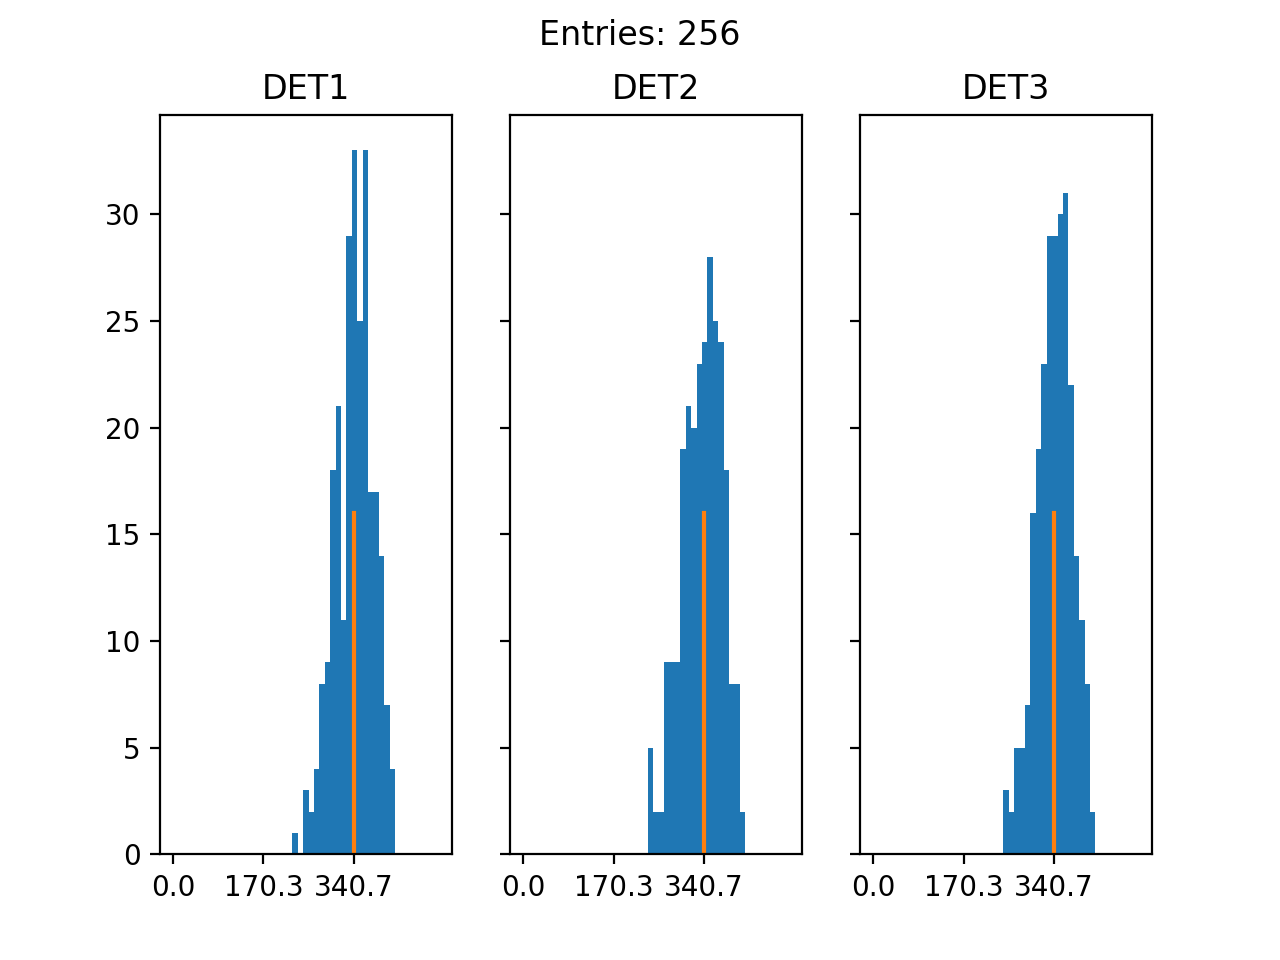

<IPython.core.display.Javascript object>


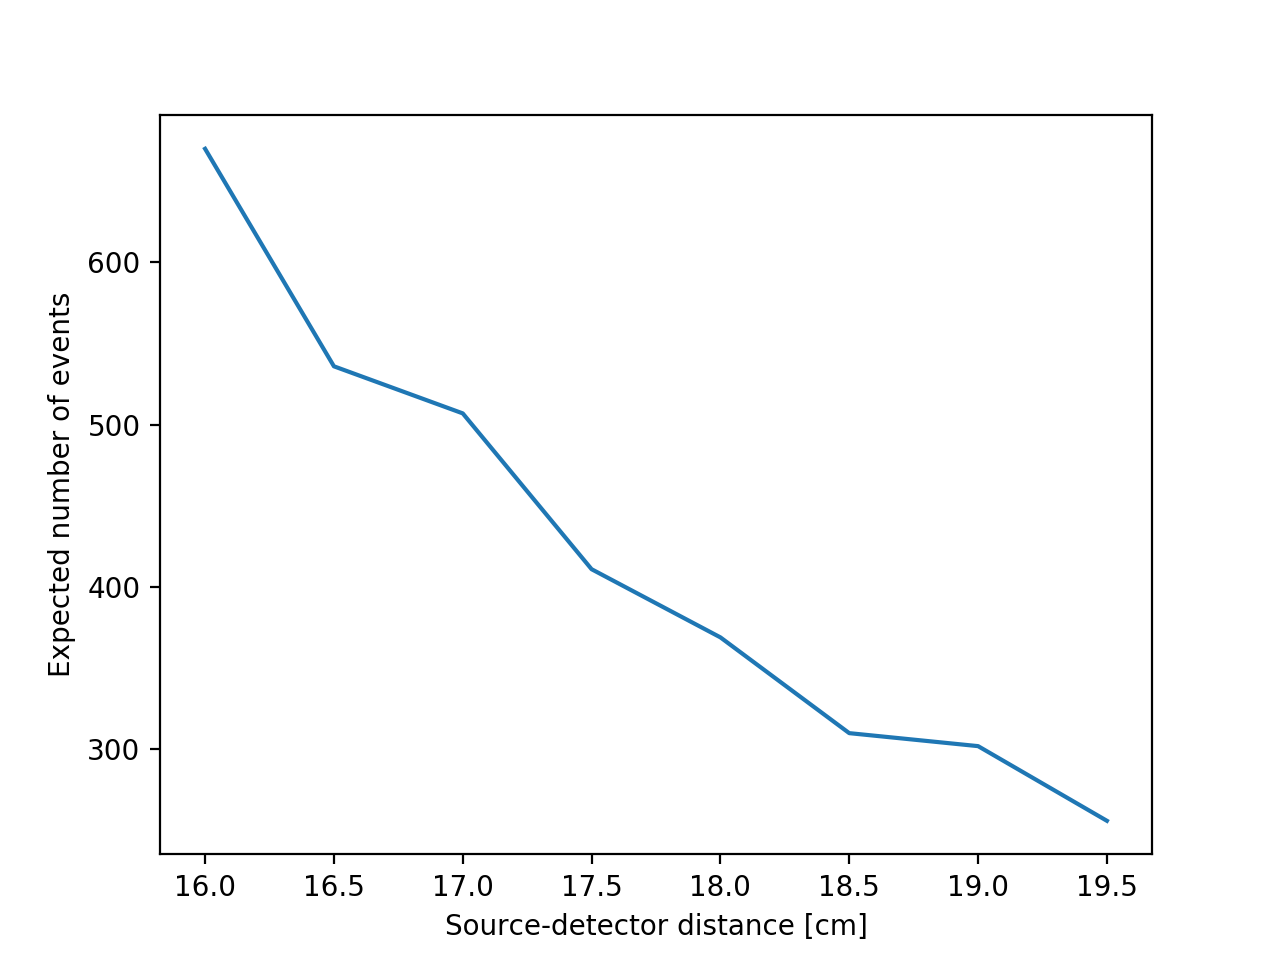

In [7]:
d1 = np.array([1,0,0])
d2 = np.array([np.cos(2*np.pi/3),np.sin(2*np.pi/3),0])
d3 = np.array([np.cos(2*np.pi/3),-np.sin(2*np.pi/3),0])

tot_events = int(1e6)
total_energy = 1022

ds = np.arange(16,20,0.5)
evcounts = np.zeros_like(ds)

for q,distance in enumerate(ds):
    D = detectors(versors=[d1,d2,d3],distances=[distance]*3,radii=[5]*3)

    for i in tqdm(range(tot_events)):
        ev = event3(total_energy,mode='polar')
        D.measure(ev,verbose=False)
    print('distance = %f' %distance)
    D.plot_spectra(numbins=50,total_energy=total_energy)
    evcounts[q] = D.evcount
    
plt.figure()
plt.plot(ds,evcounts)
plt.xlabel('Source-detector distance [cm]')
plt.ylabel('Expected number of events')
plt.show()

In [8]:
ens = np.array(C.energies)

(3, 1000001)

In [11]:
np.mean(ens)

340.66666666666674

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:11<00:00, 8442.82it/s]


<IPython.core.display.Javascript object>


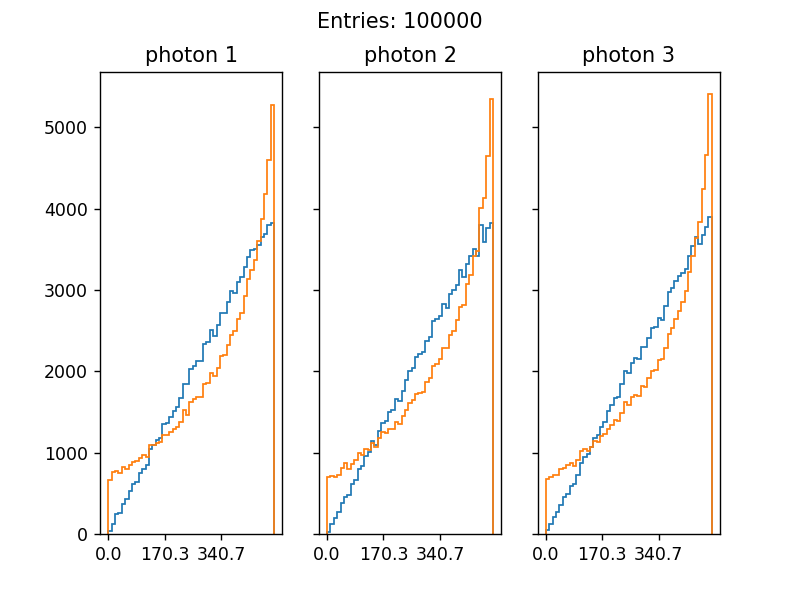

<IPython.core.display.Javascript object>


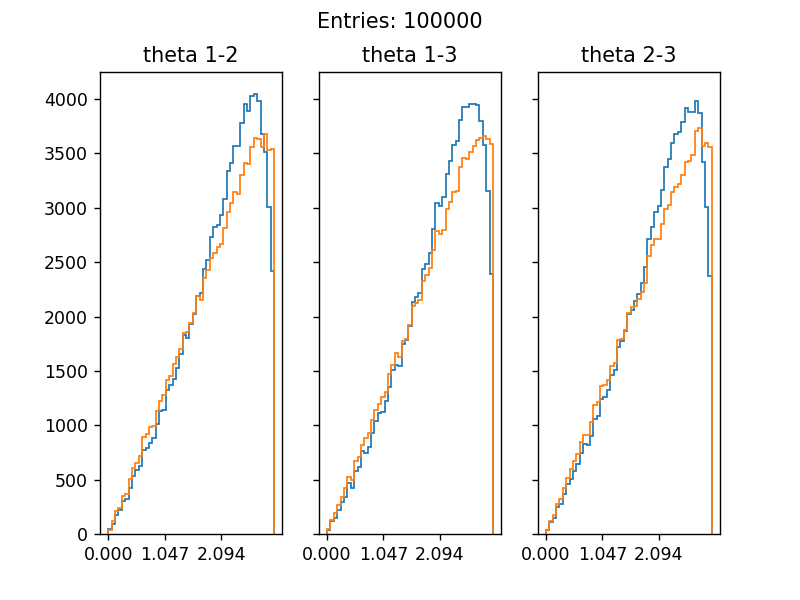

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DF6DA06080>,
      dtype=object)

In [25]:
total_energy = 1022
N = 100000
lowE = 0
highE = 340

def Filter(ev):
    if ev.es[2] > lowE and ev.es[2] < highE:
        return True
    else:
        return False

C1 = total_spectra()
C2 = total_spectra()
for i in tqdm(range(N)):
    ev = event3(total_energy,mode='energy',permute_photons=True)
    C1.measure(ev,Filter=no_Filter)
    C2.measure(ev,Filter=no_Filter,use_weights=True)
    
ax = C2.plot_energy_spectra(numbins=50,total_energy=total_energy)
C1.plot_energy_spectra(numbins=50,total_energy=total_energy,external_ax=ax)
axang = C2.plot_angular_spectra(numbins=50)
C1.plot_angular_spectra(numbins=50,external_ax=axang)

In [28]:
np.min(C2.energies)

0.004774163551631072

<IPython.core.display.Javascript object>


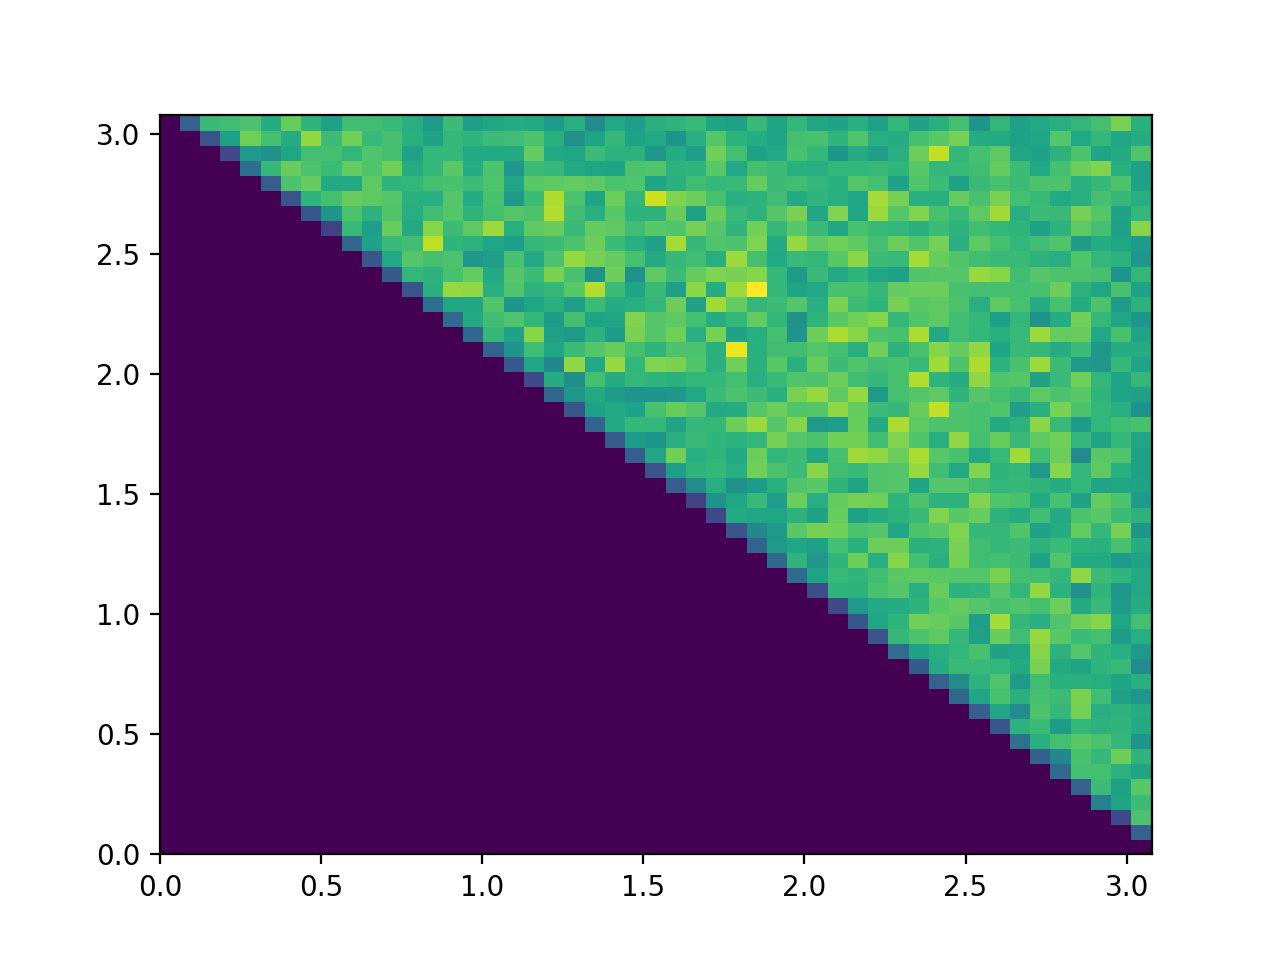

In [122]:
numbins = 50

bins = np.arange(0,np.pi,np.pi/numbins)

plt.figure()
plt.hist2d(C1.angles[0],C1.angles[1],bins=bins)
plt.show()

<IPython.core.display.Javascript object>


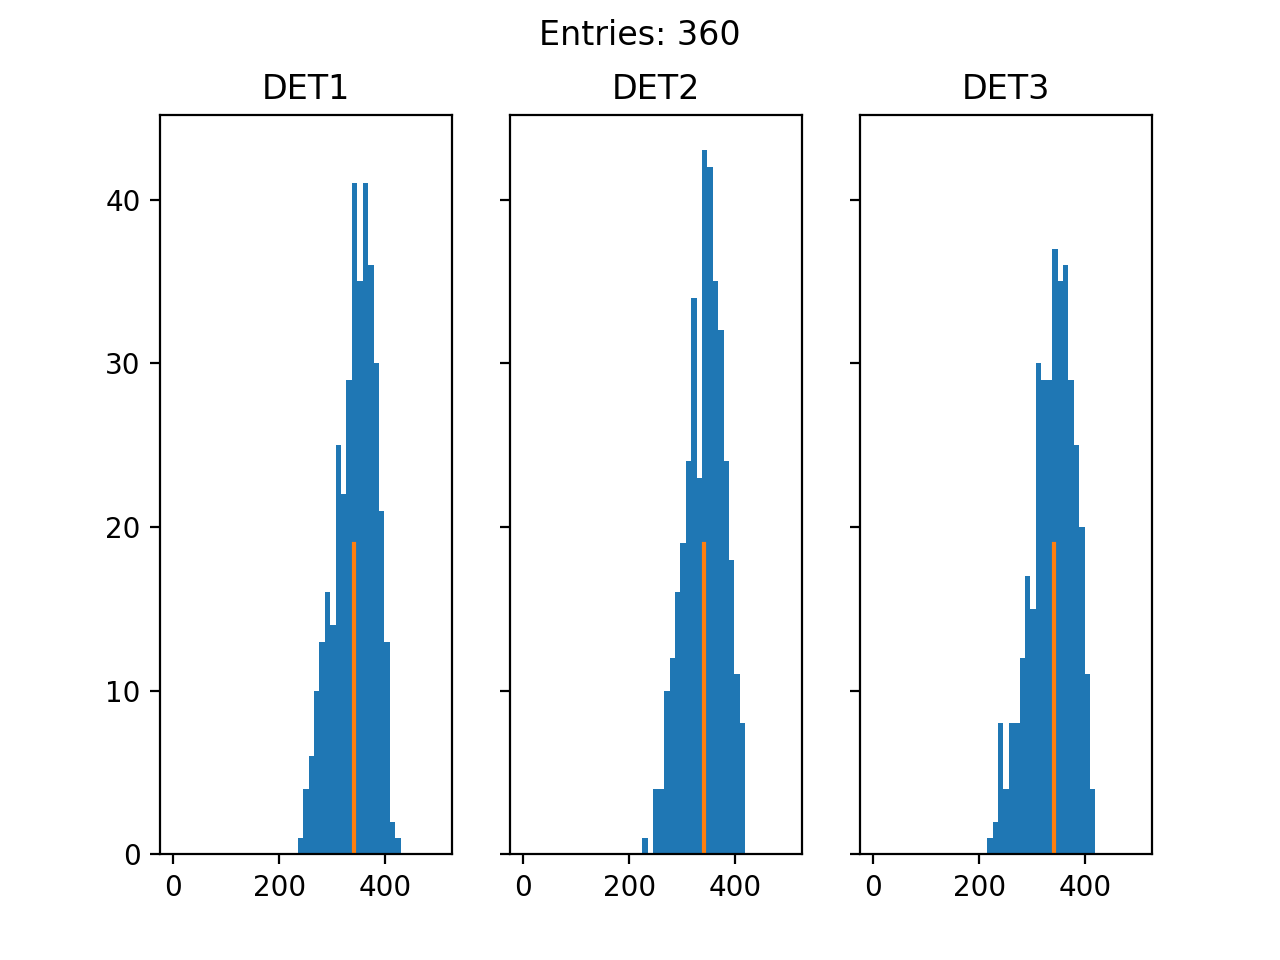

In [79]:
D.plot_spectra(numbins=50,total_energy=total_energy)